# Interpolate soundings
## vertically from irregularly-spaced pressure levels

with Julia 1.8
author: Simon de Szoeke

In [209]:
using Dates
using NCDatasets
using Interpolations
using Statistics
using PyPlot

In [171]:
# Interpolation methods
# Pressure is irregular and different for each time.

"dv converts Datetimes to numeric values. Needed for Interpolations."
dv(dt, offset=DateTime(2019,3,1)) = Dates.value(dt - offset)

# interpolation functions
function itp_sparse(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"Filter missing data from the input sounding before interpolating."
function itp(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind] .+ x[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end
itp(ds::Dataset, var::String; p=ds["pressure"][:][:]) = itp(ds[var][:][:], p) # convenience method

# example:
# itp(ds, "u_wind")

itp (generic function with 5 methods)

In [172]:
# data from NetCDF
stationname = "thrivandrum"
datestamp = Dates.format(DateTime("2019-03-01T00:00"), "yyyymmdd_HHMM") # "20190324_0000"

datapath = joinpath( "../data/igra2", stationname )
joinpath( datapath, "$(stationname)$(datestamp).nc" )

# one sounding per netcdf file
data = NCDatasets.Dataset( joinpath( datapath, "$(stationname)$(datestamp).nc" ) )

# example data - one sounding, one time
u = itp(data, "u_wind")[1000] # works here!
# 

3.1f0

In [173]:
stationname = "thrivandrum"
datapath = joinpath( "../data/igra2", stationname )

# define date range
dr = DateTime(2019,3,1):Day(1):DateTime(2019,6,30)
# datestamps = Dates.format.(dr, "yyyymmdd_HHMM")

plevs = 1020.0:-20.0:100.0

# test loading and interpolating u
u = fill( NaN, length(dr), length(plevs) ) # time, pres
for (it, time) in enumerate( DateTime(2019,3,1):Day(1):DateTime(2019,6,30) )
    datestamp = Dates.format(time, "yyyymmdd_HHMM")
    ncfilename = joinpath( datapath, "$(stationname)$(datestamp).nc" )
    if isfile( ncfilename )
        data = NCDatasets.Dataset( ncfilename )
        if sum(isfinite, data["pressure"]) > 1
            u[it, :] = itp(data, "u_wind")[ plevs ]
        end
    else
        # leave u NaNs
    end
end

In [181]:
"Fill workspace variable u with interpolated data from NC sounding files."
function interp_snd_var!( u, varname; plevs=plevs )
    fill!( u, NaN ) # guarantee to be filled with nans
    # test loading and interpolating u
    for (it, time) in enumerate( DateTime(2019,3,1):Day(1):DateTime(2019,6,30) )
        datestamp = Dates.format(time, "yyyymmdd_HHMM")
        ncfilename = joinpath( datapath, "$(stationname)$(datestamp).nc" )
        if isfile( ncfilename )
            data = NCDatasets.Dataset( ncfilename )
            if ( sum(isfinite, data[varname][:] .+ data["pressure"][:]) > 1 )
                u[it, :] = itp(data, varname)[ plevs ]
            end
        else
            # leave u NaNs
        end
    end
end


interp_snd_var!

In [182]:
# test sounding data dictionary
arr() = Array{Float64, 2}(undef, length(dr), length(plevs) ) # time, pres
soundings = Dict{String, Array}( "u_wind" => arr() ) 
interp_snd_var!( soundings["u_wind"], "u_wind" )
soundings = Dict{String, Array}( "u_wind" => arr() ) 

# append a variable to the dict
varname = "v_wind"
soundings[varname] = arr()

interp_snd_var!( soundings[varname], varname )

In [183]:
# make sounding data dictionary
varnames = [ "temperature", "dewpoint", "u_wind", "v_wind" ]
dicarr( var ) = ( var, arr() )
soundings = Dict{String, Array}( [dicarr.(varnames)...] )

# fill in with interpolated data from files
for var in varnames
    interp_snd_var!( soundings[var], var )
end

In [226]:
# functions for thermodynamics

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K

# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

"qsat(T[C], p[hPa])"
qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.
# do Tlcl(T, p, ev(p,qv))

Tlcl

In [ ]:
"mean along dims, ignoring NaNs"
nanmean(x; dims) = sum(x -> isnan(x) ? 0 : x, x, dims=dims) ./ sum(isfinite, x, dims=dims)
anom(x; dims) = x .- nanmean(x, dims=dims)

In [231]:
# physical variables
Pi = (plevs/1e3).^(-0.287)
th = Pi'.*(273.15.+soundings["temperature"])
thm = nanmean(th, dims=1)

qs = qsat.(soundings["temperature"], plevs')
q = qsat.(soundings["dewpoint"], plevs')
rh = q./qs

122×47 Matrix{Float64}:
 NaN    0.770859    0.769039    0.767212  …    0.0359414    0.0355016
 NaN    0.802961    0.740392    0.681788       0.0813725    0.057832
 NaN    0.812452    0.727481    0.650029       0.152371     0.109134
 NaN    0.781507    0.791828    0.802506       0.0857434    0.0628025
 NaN    0.794977    0.805612    0.816613       0.0396342    0.0274218
 NaN    0.798251    0.809145    0.820401  …    0.116847     0.0932873
 NaN    0.794977    0.810603    0.826858       0.0102421    0.0108433
 NaN    0.784992    0.807944    0.832023       0.138579     0.0795089
 NaN    0.750867    0.757009    0.76334        0.0879044    0.0632637
 NaN    0.78854     0.784896    0.790323       0.0941075    0.0881327
 NaN    0.78188     0.797053    0.81283   …    0.122168     0.082166
 NaN    0.811801    0.616555    0.577737       0.0251457    0.0106385
 NaN    0.821104    0.825833    0.433187       0.0252798    0.0123118
   ⋮                                      ⋱    ⋮          
 NaN    0.

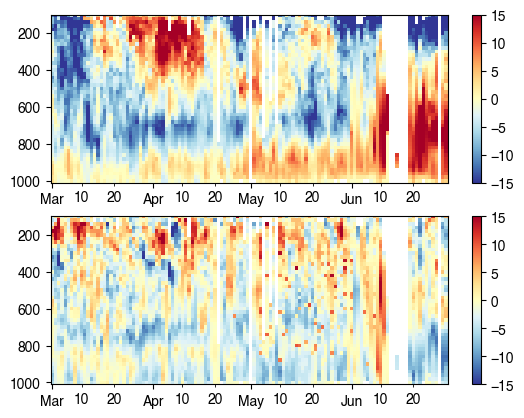

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbb50b48fd0>

In [268]:
# plot winds
mdates = matplotlib.dates

#pcolormesh(dr, plevs, u', vmin=-15, vmax=15, cmap=ColorMap("RdYlBu_r"))
ax1=subplot(2,1,1)
pcolormesh(dr, plevs, soundings["u_wind"]', vmin=-15, vmax=15, cmap=ColorMap("RdYlBu_r"))
ylim([1010, 100])
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
colorbar()
ax2=subplot(2,1,2)
pcolormesh(dr, plevs, soundings["v_wind"]', vmin=-15, vmax=15, cmap=ColorMap("RdYlBu_r"))
ylim([1010, 100])
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
colorbar()

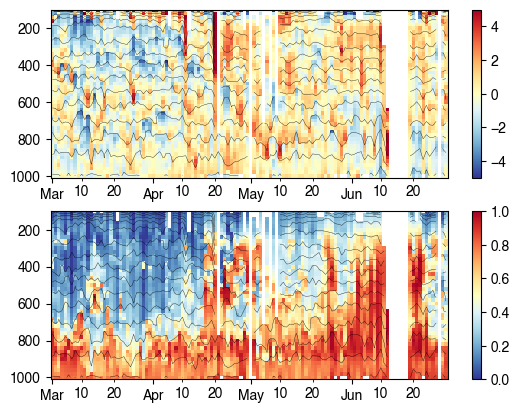

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbb506375b0>

In [267]:
ax1=subplot(2,1,1)
pc1 = pcolormesh(dr, plevs, anom(th, dims=1)', vmin=-5, vmax=5, cmap=ColorMap("RdYlBu_r"))
contour(dr, plevs, th', colors="k", linewidths=0.25, levels=20)
ylim([1010, 100])
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
colorbar(pc1)
ax2=subplot(2,1,2)
# pcolormesh(dr, plevs, 1e3*q', vmin=0, vmax=18, cmap=ColorMap("RdYlBu_r"))
pc2 = pcolormesh(dr, plevs, rh', vmin=0, vmax=1.0, cmap=ColorMap("RdYlBu_r"))
contour(dr, plevs, th', colors="k", linewidths=0.25, levels=20)
ylim([1010, 100])
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
colorbar(pc2)

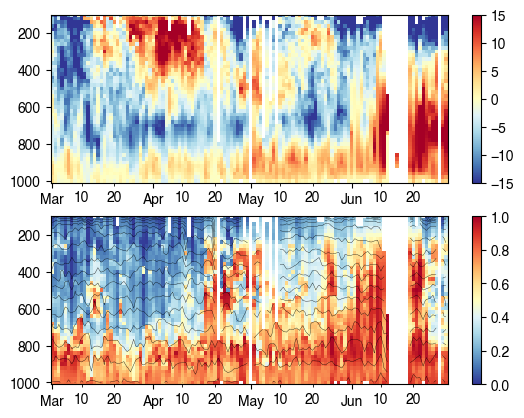

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbb51097f10>

In [269]:
ax1=subplot(2,1,1)
pcolormesh(dr, plevs, soundings["u_wind"]', vmin=-15, vmax=15, cmap=ColorMap("RdYlBu_r"))
ylim([1010, 100])
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
colorbar()

ax2=subplot(2,1,2)
# pcolormesh(dr, plevs, 1e3*q', vmin=0, vmax=18, cmap=ColorMap("RdYlBu_r"))
pc2 = pcolormesh(dr, plevs, rh', vmin=0, vmax=1.0, cmap=ColorMap("RdYlBu_r"))
contour(dr, plevs, th', colors="k", linewidths=0.25, levels=20)
ylim([1010, 100])
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
colorbar(pc2)

Onset vortex humidity precedes wind by at least 10 days.